In [ ]:
!pip install sensormotion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sensormotion: filename=sensormotion-1.1.4-py3-none-any.whl size=19675 sha256=f8732570357a626d993e511b9ab6e68558dc9b57d5bd2f4797d501729b14b6f9
  Stored in directory: /root/.cache/pip/wheels/75/d2/43/d129af476d6d0717bcdfc3b7d6ff9b15d65cccdfa21518adac
Successfully built sensormotion


In [ ]:
import numpy as np
import sensormotion as sm
with open('/content/drive/MyDrive/uci/walking_data.npz','rb') as f:
  data = np.load(f)['arr_0']

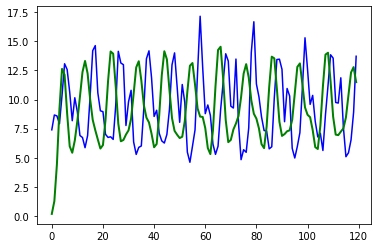

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    return signal.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

y = butter_lowpass_filter(data[1,:,0], 4, 20, 6)
plt.plot(data[0,:,0], 'b-', label='data')
plt.plot(y, 'g-', linewidth=2, label='filtered data')
plt.show()

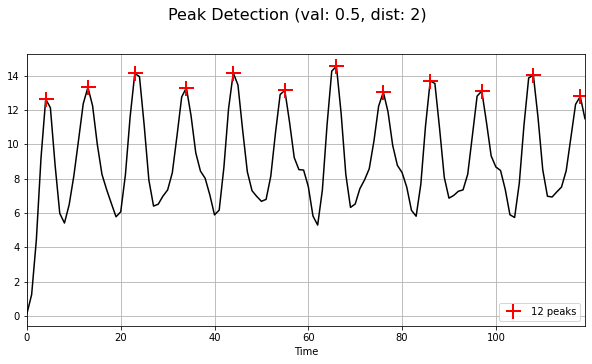

In [ ]:
peak_times, peak_values = sm.peak.find_peaks(np.arange(0,120),y,min_dist=2, peak_type='peak', plot=True)

In [ ]:
handcrafted_features = []
for i in range(data.shape[0]):
  y = butter_lowpass_filter(data[i,:,0], 4, 20, 6)
  peak_times, peak_values = sm.peak.find_peaks(np.arange(0,120),y,min_dist=2, peak_type='peak')
  step_count = sm.gait.step_count(peak_times)
  cadence = sm.gait.cadence(np.arange(0,120), peak_times)
  step_time, step_time_sd, step_time_cov = sm.gait.step_time(peak_times)
  
  ac, ac_lags = sm.signal.xcorr(y, y, scale='unbiased')
  ac_peak_times, ac_peak_values = sm.peak.find_peaks(ac_lags, ac, peak_type='peak', min_val=0.1, min_dist=2)
  step_reg, stride_reg = sm.gait.step_regularity(ac_peak_values)
  step_sym = sm.gait.step_symmetry(ac_peak_values)
  handcrafted_features.append([cadence, step_time, step_time_sd, step_time_cov, step_reg, stride_reg, step_sym])

In [ ]:
handcrafted_features = np.array(handcrafted_features)
print(handcrafted_features.shape)

(355, 7)


In [ ]:
with open('/content/drive/MyDrive/uci/walking_labels.npz','rb') as f:
  labels = np.load(f)['arr_0']
train_mask = labels<=20

In [ ]:
train_mask.shape

(355,)

In [ ]:
train_f = handcrafted_features[train_mask,:]
test_f = handcrafted_features[np.logical_not(train_mask), :]

In [ ]:
train_l = labels[train_mask]
test_l = labels[np.logical_not(train_mask)]

In [ ]:
train_f.shape

(238, 7)

In [ ]:
f = []
l = []
for i in range(train_f.shape[0]):
  for j in range(train_f.shape[0]):
    h = np.abs(train_f[i]-train_f[j]).tolist() 
    f.append(h)
    l.append(int(train_l[i]==train_l[j]))
train_pairs = np.array(f)
train_labels = np.array(l)
print(train_pairs.shape)
print(train_labels.shape)

(56644, 7)
(56644,)


In [ ]:
from sklearn.svm import SVC
clf = SVC(class_weight='balanced')
clf.fit(train_pairs, train_labels)

SVC(class_weight='balanced')

In [ ]:
clf.classes_

array([0, 1])

In [ ]:
np.unique(test_l)

array([21., 22., 23., 24., 25., 26., 27., 28., 29., 30.])

In [ ]:
from sklearn.metrics import top_k_accuracy_score

def eval_svm():
  y_pred = []
  y_true = []
  for i in range(test_l.shape[0]):
    trial = []
    for j in range(10):
      cl=j+21
      cl_samples = test_f[test_l==cl]
      trial.append(cl_samples[np.random.choice(cl_samples.shape[0])])
    x = test_f[i]
    # trial = np.concatenate(trial, axis=0)
    trial = np.vstack(trial)
    # print('trual shape is',trial.shape)
    trial = np.abs(trial - x)
    scores = clf.decision_function(trial)
    # print('scores shape is',scores.shape)
    y_pred.append(scores)
    y_true.append(test_l[i])
  y_true = np.asarray(y_true)
  y_pred = np.vstack(y_pred)
  # print('y_pred shape', y_pred.shape)
  # print('y_true shape', y_true.shape)
  t1 = top_k_accuracy_score(y_true, y_pred,k=1, labels = list(range(21,31)), normalize=True)
  t3 = top_k_accuracy_score(y_true, y_pred,k=3, labels = list(range(21,31)), normalize=True)
  t5 = top_k_accuracy_score(y_true, y_pred,k=5, labels = list(range(21,31)), normalize=True)
  print('top 1 accuracy is',t1)
  print('top 3 accuracy is', t3)
  print('top 5 accuracy is', t5)

eval_svm()

top 1 accuracy is 0.4444444444444444
top 3 accuracy is 0.6581196581196581
top 5 accuracy is 0.7863247863247863
